# 🤖 Notebook 6/6 — Fine-tuning TinyBERT para Detecção de Fake News
## Ligia NLP Challenge — Deep Learning

| Informação | Detalhe |
|---|---|
| **Modelo** | `huawei-noah/TinyBERT_General_4L_312D` — 4 camadas, 312 hidden dims, ~14M parâmetros |
| **Tarefa** | Classificação binária (0 = Real, 1 = Fake) |
| **Entrada** | `data/raw/train.csv`, `data/raw/test.csv` |
| **Saída (modelos)** | `models/deeplearning/tinybert_checkpoints/` |
| **Saída (submissão)** | `data/processed/submission_tinybert.csv` |
| **Saída (figuras)** | `reports/figures/tinybert_*.png` |
| **Notebook anterior** | `4.0-predictions.ipynb` |

> ⚠️ **Hardware:** GPU fortemente recomendada (T4/V100).

---
### Execução Local (Jupyter)
Execute a partir da pasta `notebooks/`. Os paths `../models/` e `../data/` funcionam automaticamente.

### Execução no Google Colab
1. **Ative a GPU:** `Ambiente de execução` → `Alterar tipo de execução` → `T4 GPU`
2. Faça upload de `train.csv` e `test.csv`, ou monte o Google Drive:
   ```python
   from google.colab import drive
   drive.mount('/content/drive')
   DATA_DIR = "/content/drive/MyDrive/ligia-nlp-challenge/data/raw"
   ```
3. Ajuste os caminhos de saída de `../` para `/content/drive/MyDrive/ligia-nlp-challenge/`

---


## 1. Verificação de GPU e Instalação de Dependências

In [1]:
import subprocess, sys

# Verificar se GPU está disponível
gpu_check = subprocess.run(["nvidia-smi", "--query-gpu=name,memory.total", "--format=csv,noheader"],
                           capture_output=True, text=True)
if gpu_check.returncode == 0:
    print(f"✅ GPU detectada:\n{gpu_check.stdout.strip()}")
else:
    print("⚠️  GPU não encontrada. O treinamento será lento na CPU.")


✅ GPU detectada:
NVIDIA GeForce GTX 1650, 4096 MiB


In [2]:
# Instalação das dependências (apenas no Colab)
!pip install transformers datasets accelerate -q
print("✅ Dependências instaladas!")


✅ Dependências instaladas!


In [ ]:
import os
import re
import json
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorWithPadding,
)
from datasets import Dataset as HFDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from lime.lime_text import LimeTextExplainer

# ─── CONFIGURAÇÕES GLOBAIS ────────────────────────────────────────────────────
SEED         = 42
MODEL_NAME   = "huawei-noah/TinyBERT_General_4L_312D"
NUM_LABELS   = 2
MAX_LEN      = 256     # chars → tokens (reduzido para caber na memória)
BATCH_SIZE   = 16     # reduza para 16 se der OOM
EPOCHS       = 10
LR           = 2e-5
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01
DROPOUT       = 0.2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"✅ Bibliotecas carregadas!")
print(f"   Transformers: {transformers.__version__}")
print(f"   PyTorch     : {torch.__version__}")
print(f"   Dispositivo : {DEVICE.upper()}")
if DEVICE == "cuda":
    print(f"   GPU         : {torch.cuda.get_device_name(0)}")
    print(f"   VRAM        : {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


✅ Bibliotecas carregadas!
   Transformers: 4.49.0
   PyTorch     : 2.6.0+cu124
   Dispositivo : CUDA
   GPU         : NVIDIA GeForce GTX 1650
   VRAM        : 4.3 GB
   ⚠️  VRAM < 6 GB — usando BATCH_SIZE=8 para evitar OOM


## 2. Carregamento dos Dados

> ⚠️ **Execute apenas UMA das duas células abaixo**, conforme seu ambiente:
> - **Célula A** → Google Colab (upload ou Google Drive)
> - **Célula B** → Execução local (`notebooks/` como diretório de trabalho)


In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║  CÉLULA A — GOOGLE COLAB                                                   ║
# ║  Execute esta célula se estiver no Colab.                                   ║
# ║  Opção 1: faça upload dos CSVs para o diretório raiz do Colab.              ║
# ║  Opção 2: monte o Google Drive (descomente as linhas abaixo).               ║
# ╚══════════════════════════════════════════════════════════════════════════════╝

# ─── Opção 1: Upload direto (arquivos na raiz do Colab) ──────────────────────
DATA_DIR = "."

# ─── Opção 2: Google Drive (descomente para usar) ────────────────────────────
# from google.colab import drive
# drive.mount('/content/drive')
# DATA_DIR = "/content/drive/MyDrive/ligia-nlp-challenge/data/raw"

TRAIN_PATH = os.path.join(DATA_DIR, "train.csv")
TEST_PATH  = os.path.join(DATA_DIR, "test.csv")

df_train = pd.read_csv(TRAIN_PATH)
df_test  = pd.read_csv(TEST_PATH)

print(f"✅ [COLAB] Dados carregados de: {DATA_DIR}")
print(f"   Train : {df_train.shape}  |  Colunas: {list(df_train.columns)}")
print(f"   Test  : {df_test.shape}   |  Colunas: {list(df_test.columns)}")
print(f"\nDistribuição de classes:\n{df_train['label'].value_counts()}")
df_train.head(3)


FileNotFoundError: [Errno 2] No such file or directory: '.\\data/train.csv'

In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║  CÉLULA B — EXECUÇÃO LOCAL                                                 ║
# ║  Execute esta célula se estiver rodando localmente (VS Code / Jupyter).     ║
# ║  Assumindo que o working dir é  notebooks/                                  ║
# ╚══════════════════════════════════════════════════════════════════════════════╝

DATA_DIR = "../data/raw"

TRAIN_PATH = os.path.join(DATA_DIR, "train.csv")
TEST_PATH  = os.path.join(DATA_DIR, "test.csv")

assert os.path.exists(TRAIN_PATH), f"Arquivo não encontrado: {TRAIN_PATH}"
assert os.path.exists(TEST_PATH),  f"Arquivo não encontrado: {TEST_PATH}"

df_train = pd.read_csv(TRAIN_PATH)
df_test  = pd.read_csv(TEST_PATH)

print(f"✅ [LOCAL] Dados carregados de: {os.path.abspath(DATA_DIR)}")
print(f"   Train : {df_train.shape}  |  Colunas: {list(df_train.columns)}")
print(f"   Test  : {df_test.shape}   |  Colunas: {list(df_test.columns)}")
print(f"\nDistribuição de classes:\n{df_train['label'].value_counts()}")
df_train.head(3)


## 3. Pré-processamento do Texto

In [31]:
def clean_text(text: str) -> str:
    """Limpeza leve: preserva pontuação e maiúsculas (BERT é case-insensitive no TinyBERT)."""
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+|www\S+", " ", text)   # remove URLs
    text = re.sub(r"<.*?>", " ", text)              # remove HTML
    text = re.sub(r"\s+", " ", text).strip()
    return text


def build_input(df: pd.DataFrame, max_chars: int = 1024) -> pd.Series:
    """Combina title e text com separador [SEP], truncando para max_chars."""
    title = df["title"].fillna("").apply(clean_text)
    text  = df["text"].fillna("").apply(clean_text).str[:max_chars]
    return title + " [SEP] " + text


df_train["input_text"] = build_input(df_train)
df_test["input_text"]  = build_input(df_test)

print(f"Exemplos de input (primeiros 200 chars):")
for i in range(2):
    print(f"\n[{i}] Label={df_train['label'].iloc[i]}")
    print(df_train["input_text"].iloc[i][:200])


Exemplos de input (primeiros 200 chars):

[0] Label=0
Exclusive: Pentagon, Lockheed near deal on $9 billion F-35 contract - sources [SEP] WASHINGTON (Reuters) - The U.S. Department of Defense and Lockheed Martin Corp (LMT.N) are close to deal for a contr

[1] Label=1
“HILL”ARIOUS…MUST SEE! IOWA PARADE GOERS Treated To “Hillary In Prison” Float…Water Balloon Passed Out To Throw At Her [SEP] HILL larious! If this was a Donald Trump pi ata, the media would be all ove


## 4. Tokenização com TinyBERT

O TinyBERT usa o mesmo tokenizador WordPiece do BERT original. A tokenização aplica:

$$\text{input} = [\text{CLS}] + \text{tokens}_{title} + [\text{SEP}] + \text{tokens}_{text} + [\text{SEP}]$$



In [ ]:
print(f"Carregando tokenizador: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"✅ Tokenizador carregado | Vocab size: {tokenizer.vocab_size}")

# Demonstração
sample = df_train["input_text"].iloc[0]
enc = tokenizer(sample, max_length=MAX_LEN, truncation=True)
print(f"\nExemplo de tokenização:")
print(f"  Texto (100 chars): {sample[:100]}")
print(f"  Nº de tokens     : {len(enc['input_ids'])}")
print(f"  Primeiros tokens : {tokenizer.convert_ids_to_tokens(enc['input_ids'][:15])}")

# ─── DISTRIBUIÇÃO DO COMPRIMENTO DOS TEXTOS ───────────────────────────────────
token_lengths = []
sample_size = min(500, len(df_train))
for txt in df_train["input_text"].sample(sample_size, random_state=SEED):
    ids = tokenizer(txt, truncation=False)["input_ids"]
    token_lengths.append(len(ids))

print(f"\nComprimento de tokens (amostra {sample_size}):")
print(f"  Mediana : {np.median(token_lengths):.0f}")
print(f"  Pct95   : {np.percentile(token_lengths, 95):.0f}")
print(f"  Max     : {np.max(token_lengths)}")
print(f"  → MAX_LEN={MAX_LEN} captura ~{(np.array(token_lengths) <= MAX_LEN).mean()*100:.1f}% dos textos")


Carregando tokenizador: huawei-noah/TinyBERT_General_4L_312D
✅ Tokenizador carregado | Vocab size: 30522

Exemplo de tokenização:
  Texto (100 chars): Exclusive: Pentagon, Lockheed near deal on $9 billion F-35 contract - sources [SEP] WASHINGTON (Reut
  Nº de tokens     : 240
  Primeiros tokens : ['[CLS]', '[UNK]', ':', '[UNK]', ',', '[UNK]', 'near', 'deal', 'on', '$', '9', 'billion', '[UNK]', '-', '35']

Comprimento de tokens (amostra 500):
  Mediana : 213
  Pct95   : 239
  Max     : 270
  → MAX_LEN=256 captura ~99.4% dos textos


## 5. Preparação do Dataset 

In [33]:
# ─── SPLIT TREINO / VALIDAÇÃO ─────────────────────────────────────────────────
X = df_train["input_text"].values
y = df_train["label"].values

X_train_raw, X_val_raw, y_train_arr, y_val_arr = train_test_split(
    X, y, test_size=0.15, random_state=SEED, stratify=y
)
print(f"Treino    : {len(X_train_raw)}")
print(f"Validação : {len(X_val_raw)}")
print(f"Teste     : {len(df_test)}")

# ─── FUNÇÃO DE TOKENIZAÇÃO ────────────────────────────────────────────────────
def tokenize_fn(examples):
    return tokenizer(
        examples["text"],
        max_length=MAX_LEN,
        truncation=True,
        padding=False,   # padding dinâmico via DataCollatorWithPadding
    )

# ─── CRIAR HF DATASETS ────────────────────────────────────────────────────────
train_hf = HFDataset.from_dict({"text": X_train_raw.tolist(), "labels": y_train_arr.tolist()})
val_hf   = HFDataset.from_dict({"text": X_val_raw.tolist(),   "labels": y_val_arr.tolist()})
test_hf  = HFDataset.from_dict({"text": df_test["input_text"].tolist()})

train_hf = train_hf.map(tokenize_fn, batched=True, remove_columns=["text"])
val_hf   = val_hf.map(tokenize_fn,   batched=True, remove_columns=["text"])
test_hf  = test_hf.map(tokenize_fn,  batched=True, remove_columns=["text"])

train_hf.set_format("torch")
val_hf.set_format("torch")
test_hf.set_format("torch")

print(f"\n✅ Datasets criados!")
print(f"   Colunas treino: {train_hf.column_names}")
print(f"   Exemplo (shape input_ids): {train_hf[0]['input_ids'].shape}")


Treino    : 19417
Validação : 3427
Teste     : 5712


Map:   0%|          | 0/19417 [00:00<?, ? examples/s]

Map:   0%|          | 0/3427 [00:00<?, ? examples/s]

Map:   0%|          | 0/5712 [00:00<?, ? examples/s]


✅ Datasets criados!
   Colunas treino: ['labels', 'input_ids', 'token_type_ids', 'attention_mask']
   Exemplo (shape input_ids): torch.Size([222])


## 6. Carregamento do Modelo TinyBERT

O modelo usa **destilação de conhecimento** a partir do BERT-base para manter performance com muito menos parâmetros.


In [42]:
from transformers import AutoConfig

# ─── CARREGAR MODELO COM DROPOUT CUSTOMIZADO ──────────────────────────────────
config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels    = NUM_LABELS,
    id2label      = {0: "Real", 1: "Fake"},
    label2id      = {"Real": 0, "Fake": 1},
    hidden_dropout_prob          = 0.2,   # dropout nas camadas ocultas
    attention_probs_dropout_prob = 0.2,   # dropout na atenção
    classifier_dropout           = 0.3,   # dropout extra antes do classificador
)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config = config,
)
model = model.to(DEVICE)

Loading weights:   0%|          | 0/71 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: huawei-noah/TinyBERT_General_4L_312D
Key                                        | Status     | 
-------------------------------------------+------------+-
fit_denses.{0, 1, 2, 3, 4}.weight          | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
fit_denses.{0, 1, 2, 3, 4}.bias            | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not o

## 7. Configuração e Treinamento com HuggingFace Trainer

In [52]:
import random
import torch

class AugmentedCollator:
    """Aplica token dropout (zera tokens aleatórios) como data augmentation."""
    def __init__(self, tokenizer, token_dropout=0.05):
        self.base     = DataCollatorWithPadding(tokenizer=tokenizer)
        self.p_drop   = token_dropout

    def __call__(self, features):
        batch = self.base(features)
        if self.p_drop > 0:
            ids   = batch["input_ids"]
            mask  = (torch.rand_like(ids, dtype=torch.float) > self.p_drop)
            # preserva [CLS], [SEP] e padding
            pad_mask = batch["attention_mask"].bool()
            batch["input_ids"] = ids * (mask | ~pad_mask).long()
        return batch

data_collator = AugmentedCollator(tokenizer, token_dropout=0.05)

In [ ]:
# ─── FUNÇÃO DE MÉTRICAS ───────────────────────────────────────────────────────
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1  = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "f1_macro": f1}


# ─── TRAINING ARGUMENTS ───────────────────────────────────────────────────────
# Execução local:  output_dir = "../models/deeplearning/tinybert_checkpoints"
# Execução Colab:  output_dir = "/content/drive/MyDrive/ligia-nlp-challenge/models/deeplearning/tinybert_checkpoints"
CHECKPOINT_DIR = "../models/deeplearning/tinybert_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

training_args = TrainingArguments(
    output_dir                  = CHECKPOINT_DIR,
    num_train_epochs            = EPOCHS,
    per_device_train_batch_size = BATCH_SIZE,
    per_device_eval_batch_size  = BATCH_SIZE * 2,
    learning_rate               = LR,
    weight_decay                = 0.05,           # ← L2 mais forte
    warmup_ratio                = 0.15,           # ← mais warmup
    lr_scheduler_type           = "cosine",
    label_smoothing_factor      = 0.1,            # ← suaviza targets (0=Real, 1=Fake → 0.05, 0.95)
    eval_strategy               = "epoch",
    save_strategy               = "epoch",
    load_best_model_at_end      = True,
    metric_for_best_model       = "f1_macro",
    greater_is_better           = True,
    logging_steps               = 50,
    fp16                        = (DEVICE == "cuda"),
    dataloader_num_workers      = 2,
    report_to                   = "none",
    seed                        = SEED,
    # ── anti-overfitting extras ──────────────────
    max_grad_norm               = 1.0,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = train_hf,
    eval_dataset    = val_hf,
    # tokenizer       = tokenizer, # REMOVIDO: O argumento 'tokenizer' não é mais aceito diretamente pelo Trainer
    data_collator   = data_collator,
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)],
)

print("✅ Trainer configurado!")
print(f"   Epochs            : {EPOCHS}")
print(f"   Batch size (treino): {BATCH_SIZE}")
print(f"   Learning rate     : {LR}")
print(f"   FP16 (GPU)        : {DEVICE == 'cuda'}")
print(f"\n   Steps por epoch   : {len(train_hf) // BATCH_SIZE}")
print(f"   Checkpoints em    : {CHECKPOINT_DIR}")


warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


✅ Trainer configurado!
   Epochs            : 10
   Batch size (treino): 16
   Learning rate     : 2e-05
   FP16 (GPU)        : True

   Steps por epoch   : 1213


In [54]:
# ─── TREINAMENTO ──────────────────────────────────────────────────────────────
print("🚀 Iniciando treinamento do TinyBERT...")

train_result = trainer.train()

print("\n✅ Treinamento concluído!")
print(f"   Tempo total    : {train_result.metrics['train_runtime']:.0f}s")
print(f"   Loss final     : {train_result.metrics['train_loss']:.4f}")
print(f"   Samples/seg    : {train_result.metrics['train_samples_per_second']:.1f}")


🚀 Iniciando treinamento do TinyBERT...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.198860,0.200313,0.999708,0.999611
2,0.198848,0.203201,0.998541,0.998053
3,0.198834,0.199886,0.999708,0.999611
4,0.198839,0.199866,0.999708,0.999611


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias'].
There were unexpected keys in the checkp


✅ Treinamento concluído!
   Tempo total    : 280s
   Loss final     : 0.1996
   Samples/seg    : 693.1


## 8. Avaliação na Validação

In [55]:
# ─── AVALIAÇÃO FINAL NA VALIDAÇÃO ────────────────────────────────────────────
eval_metrics = trainer.evaluate()
print("=== Métricas de Validação (melhor checkpoint) ===")
for k, v in eval_metrics.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

# Predições detalhadas para o classification report
pred_output = trainer.predict(val_hf)
y_pred_val  = np.argmax(pred_output.predictions, axis=-1)
y_true_val  = np.array(y_val_arr)

print("\n=== Classification Report ===")
print(classification_report(y_true_val, y_pred_val, target_names=["Real", "Fake"]))


=== Métricas de Validação (melhor checkpoint) ===
  eval_loss: 0.2003
  eval_accuracy: 0.9997
  eval_f1_macro: 0.9996
  eval_runtime: 4.1844
  eval_samples_per_second: 818.9910
  eval_steps_per_second: 25.8100
  epoch: 4.0000

=== Classification Report ===
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      2570
        Fake       1.00      1.00      1.00       857

    accuracy                           1.00      3427
   macro avg       1.00      1.00      1.00      3427
weighted avg       1.00      1.00      1.00      3427



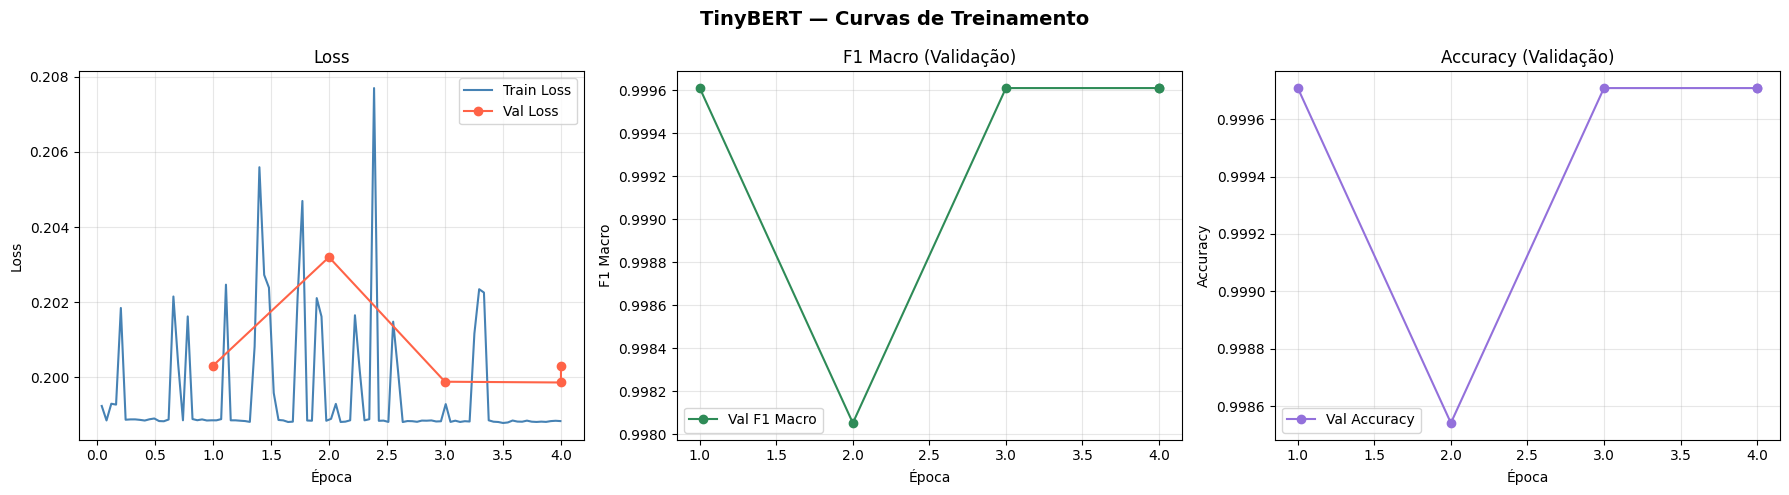

In [ ]:
# ─── CURVAS DE TREINAMENTO ────────────────────────────────────────────────────
import os
log_history = trainer.state.log_history

train_loss = [(h["epoch"], h["loss"])       for h in log_history if "loss" in h and "eval_loss" not in h]
eval_data  = [(h["epoch"], h["eval_loss"], h.get("eval_f1_macro", None), h.get("eval_accuracy", None))
              for h in log_history if "eval_loss" in h]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("TinyBERT — Curvas de Treinamento", fontsize=14, fontweight="bold")

# Loss
if train_loss:
    epochs_t, losses_t = zip(*train_loss)
    axes[0].plot(epochs_t, losses_t, label="Train Loss", color="steelblue")
if eval_data:
    epochs_e, eval_losses, eval_f1s, eval_accs = zip(*eval_data)
    axes[0].plot(epochs_e, eval_losses, label="Val Loss", color="tomato", marker="o")
axes[0].set_xlabel("Época"); axes[0].set_ylabel("Loss"); axes[0].set_title("Loss")
axes[0].legend(); axes[0].grid(True, alpha=0.3)

# F1 Macro
if eval_data and eval_f1s[0] is not None:
    axes[1].plot(epochs_e, eval_f1s, color="seagreen", marker="o", label="Val F1 Macro")
    axes[1].set_xlabel("Época"); axes[1].set_ylabel("F1 Macro"); axes[1].set_title("F1 Macro (Validação)")
    axes[1].legend(); axes[1].grid(True, alpha=0.3)

# Accuracy
if eval_data and eval_accs[0] is not None:
    axes[2].plot(epochs_e, eval_accs, color="mediumpurple", marker="o", label="Val Accuracy")
    axes[2].set_xlabel("Época"); axes[2].set_ylabel("Accuracy"); axes[2].set_title("Accuracy (Validação)")
    axes[2].legend(); axes[2].grid(True, alpha=0.3)

plt.tight_layout()

FIGURES_DIR = "../reports/figures"
os.makedirs(FIGURES_DIR, exist_ok=True)
fig_path = os.path.join(FIGURES_DIR, "tinybert_training_curves.png")
plt.savefig(fig_path, dpi=150, bbox_inches="tight")
print(f"📊 Curvas salvas em: {fig_path}")
plt.show()


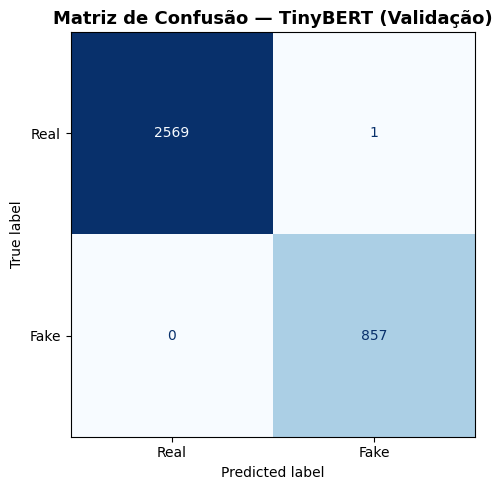

In [ ]:
# ─── MATRIZ DE CONFUSÃO ───────────────────────────────────────────────────────
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_val, y_pred_val)
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(ax=ax, colorbar=False, cmap="Blues")
ax.set_title("Matriz de Confusão — TinyBERT (Validação)", fontsize=13, fontweight="bold")
plt.tight_layout()

FIGURES_DIR = "../reports/figures"
os.makedirs(FIGURES_DIR, exist_ok=True)
cm_path = os.path.join(FIGURES_DIR, "tinybert_confusion_matrix.png")
plt.savefig(cm_path, dpi=150, bbox_inches="tight")
print(f"📊 Matriz de confusão salva em: {cm_path}")
plt.show()


## 9. Geração de Predições para Submissão

In [ ]:
# ─── PREDIÇÕES NO TESTE ───────────────────────────────────────────────────────
print("Gerando predições no conjunto de teste...")
test_output    = trainer.predict(test_hf)
y_test_pred    = np.argmax(test_output.predictions, axis=-1)
y_test_proba   = torch.softmax(torch.tensor(test_output.predictions), dim=-1).numpy()

submission = pd.DataFrame({
    "id":          df_test["id"],
    "label":       y_test_pred,
    "prob_real":   y_test_proba[:, 0].round(4),
    "prob_fake":   y_test_proba[:, 1].round(4),
})
submission_clean = submission[["id", "label"]]

SUBMISSION_PATH = "../data/processed/submission_tinybert.csv"
submission_clean.to_csv(SUBMISSION_PATH, index=False)

print(f"✅ Submission salva: {SUBMISSION_PATH}")
print(f"\nDistribuição prevista:")
print(submission_clean["label"].value_counts().rename({0: "Real", 1: "Fake"}))
print(f"\nPrimeiras linhas:")
display(submission_clean.head())


Gerando predições no conjunto de teste...


✅ Submission salva: submission_tinybert.csv

Distribuição prevista:
label
Real    4285
Fake    1427
Name: count, dtype: int64

Primeiras linhas:


,id,label
0,5398,1
1,5503,1
2,23151,0
3,12669,0
4,27864,0


Texto    : Obama surprises Vice President Biden with Medal of Freedom [SEP] WASHINGTON (Reuters) - U.S. President Barack Obama surp...
Predição : Real  (Real: 0.9584 | Fake: 0.0416)
Explicando classe: Real



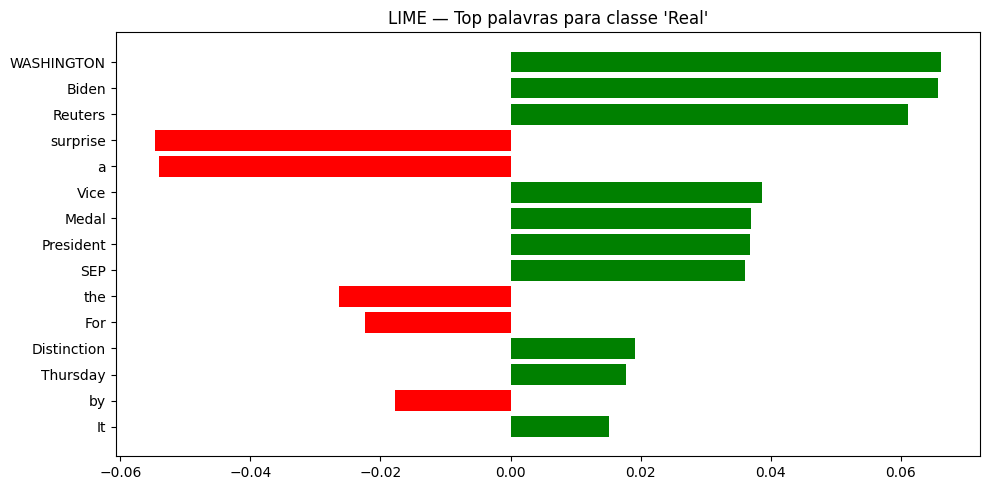

────────────────────────────────────────────────────────────────────────────────
Texto    : Restaurant Owner OBLITERATES Customer Who Said Woman’s Death Ruined Her New Year’s (IMAGES) [SEP] Working in the service...
Predição : Fake  (Real: 0.0412 | Fake: 0.9588)
Explicando classe: Fake



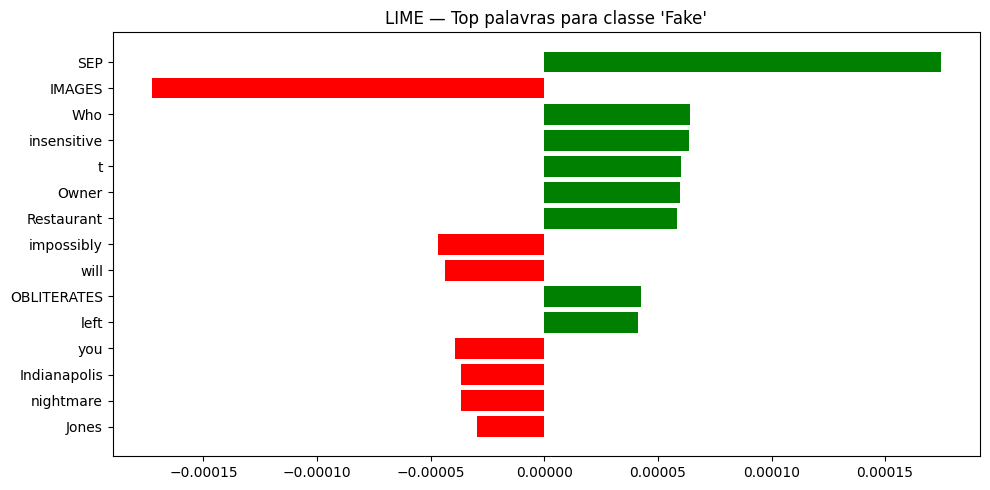

────────────────────────────────────────────────────────────────────────────────
Texto    : BOOM! 4 VENUES CANCEL KATHY GRIFFIN Appearances After She Blames Trump For Her Career Ending Decision To Pose With His S...
Predição : Fake  (Real: 0.0410 | Fake: 0.9590)
Explicando classe: Fake



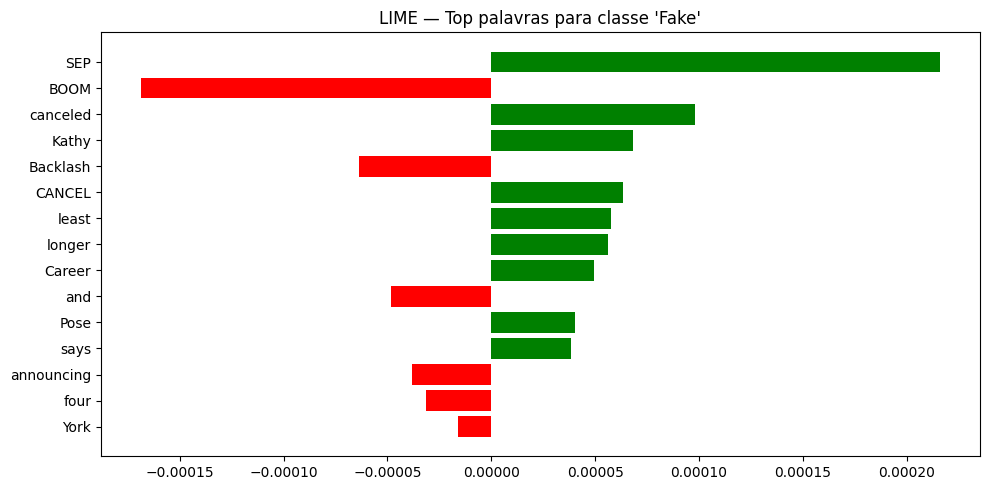

────────────────────────────────────────────────────────────────────────────────


In [ ]:
# ─── FUNÇÃO DE PREDIÇÃO PARA O LIME ──────────────────────────────────────────
def predict_lime(texts):
    inputs = tokenizer(
        list(texts),
        return_tensors="pt",
        truncation=True,
        max_length=128,
        padding=True
    ).to(DEVICE)

    with torch.no_grad():
        logits = model(**inputs).logits

    return torch.softmax(logits, dim=-1).cpu().numpy()

# ─── EXPLAINER ────────────────────────────────────────────────────────────────
explainer_lime = LimeTextExplainer(
    class_names=["Real", "Fake"],
    split_expression=r"\W+",
    random_state=SEED
)

# ─── FUNÇÃO REUTILIZÁVEL ──────────────────────────────────────────────────────
def explain_lime(text, num_features=15, num_samples=500, label=None):
    proba = predict_lime([text])[0]
    pred_class = int(np.argmax(proba))
    class_names = ["Real", "Fake"]

    if label is None:
        label = pred_class

    exp = explainer_lime.explain_instance(
        text,
        predict_lime,
        num_features=num_features,
        num_samples=num_samples,
        labels=[label]
    )

    print(f"Texto    : {text[:120]}...")
    print(f"Predição : {class_names[pred_class]}  (Real: {proba[0]:.4f} | Fake: {proba[1]:.4f})")
    print(f"Explicando classe: {class_names[label]}\n")

    fig = exp.as_pyplot_figure(label=label)
    fig.set_size_inches(10, 5)
    plt.title(f"LIME — Top palavras para classe '{class_names[label]}'")
    plt.tight_layout()
    plt.show()

    return exp

# ─── TESTAR ───────────────────────────────────────────────────────────────────
for i in [0, 1, 2]:
    text = X_val_raw[i]
    explain_lime(text)
    print("─" * 80)


=== REAL ===
Texto    : Obama surprises Vice President Biden with Medal of Freedom [SEP] WASHINGTON (Reuters) - U.S. President Barack Obama surp...
Predição : Real  (Real: 0.9584 | Fake: 0.0416)
Explicando classe: Real



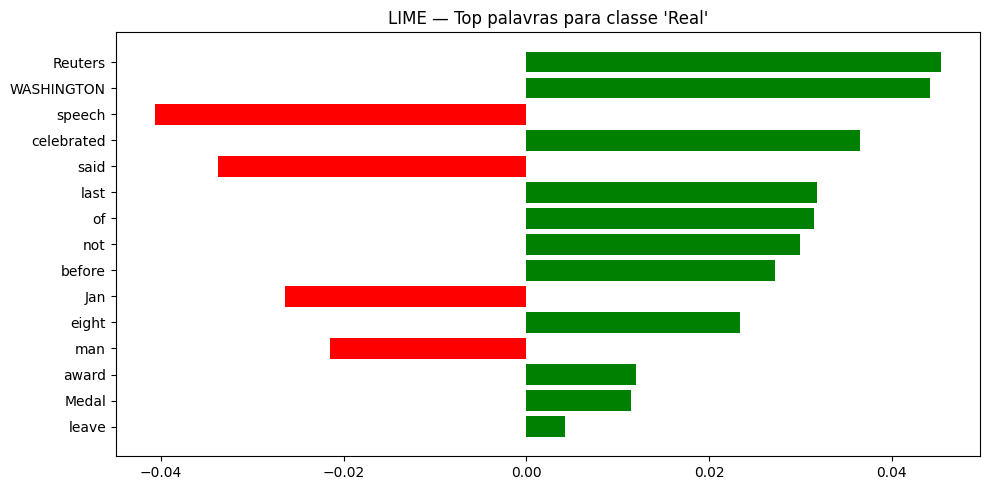

Predição : Real  (Real: 0.9584 | Fake: 0.0416)


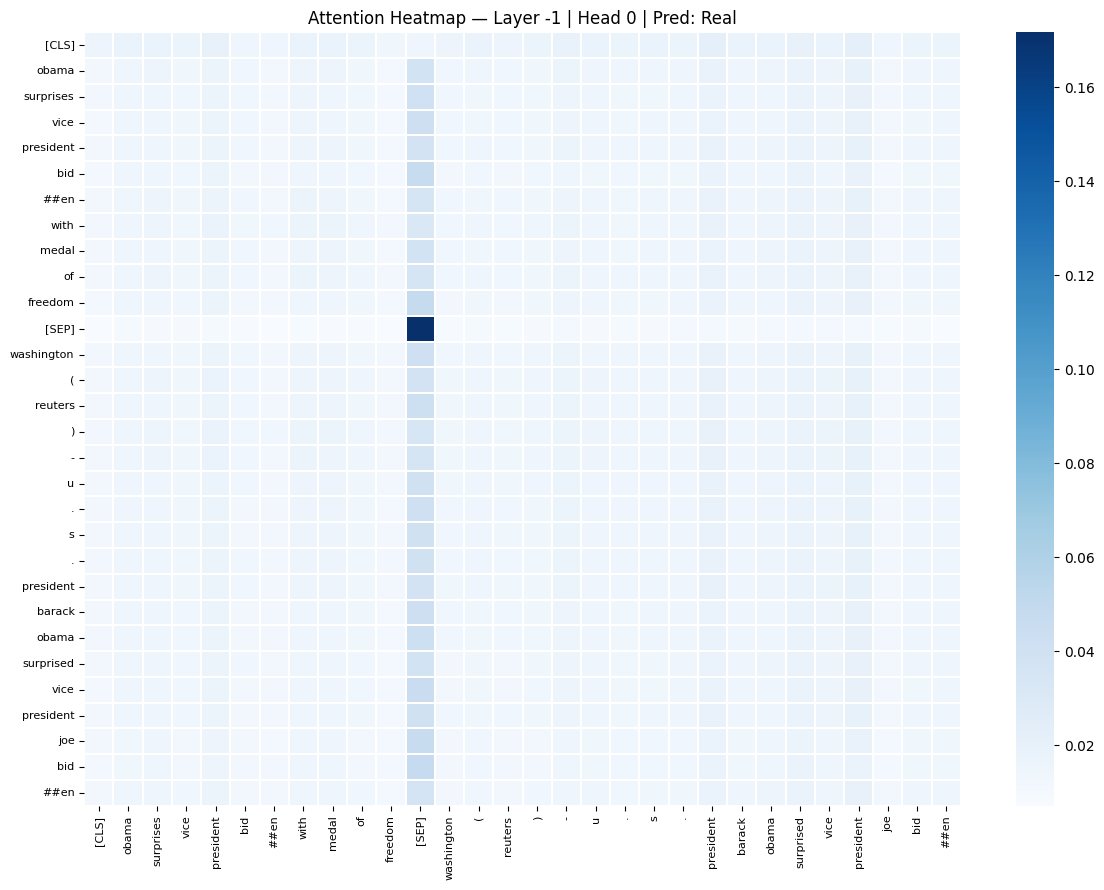

=== FAKE ===
Texto    : Restaurant Owner OBLITERATES Customer Who Said Woman’s Death Ruined Her New Year’s (IMAGES) [SEP] Working in the service...
Predição : Fake  (Real: 0.0412 | Fake: 0.9588)
Explicando classe: Fake



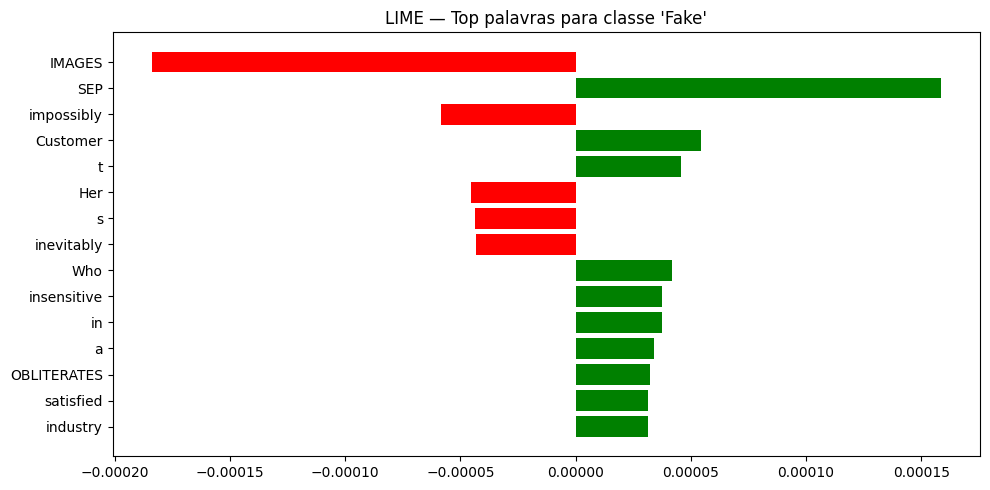

Predição : Fake  (Real: 0.0412 | Fake: 0.9588)


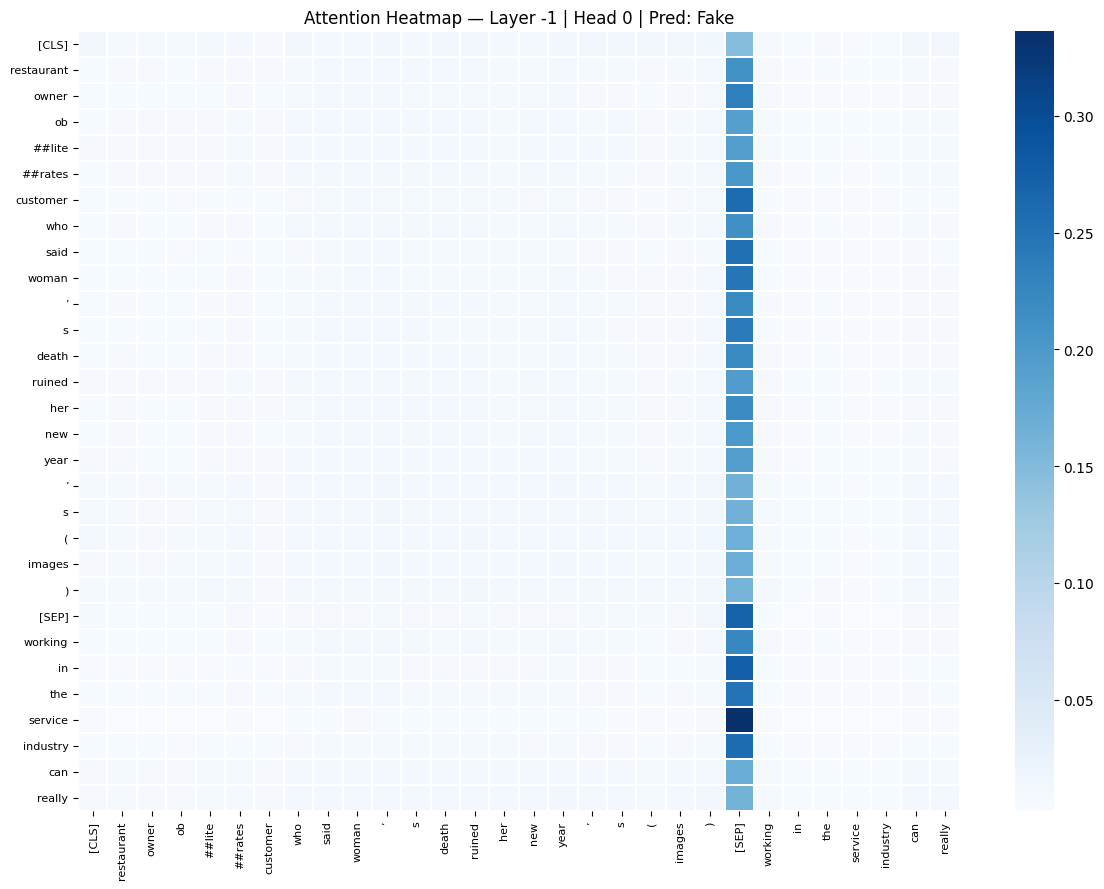

In [ ]:
# ─── COMPARAÇÃO LIME: Real vs Fake ────────────────────────────────────────────
# Mesmo protocolo usado nos modelos clássicos (notebook 3.0) → comparação direta
real_text = X_val_raw[y_val_arr == 0][0]
fake_text = X_val_raw[y_val_arr == 1][0]

print("=" * 80)
print("EXEMPLO — REAL (label=0)")
print("=" * 80)
explain_lime(real_text)

print("=" * 80)
print("EXEMPLO — FAKE (label=1)")
print("=" * 80)
explain_lime(fake_text)
